In [32]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers, losses, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
rc['font.size']=12
import os
from posydon.grids.psygrid import PSyGrid
from posydon.interpolation.IF_interpolation import BaseIFInterpolator
import warnings
import plotly
import plotly.express as px
import plotly.graph_objs as go
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir("/projects/b1119/eteng/psygrid_dataset")
data = np.load("normalized_logrho_profiles.npy",allow_pickle=True)
valid = np.load("normalized_logrho_validation_profiles.npy", allow_pickle=True)

In [3]:
class RhoProf:
    def __init__(self, dataset):
        self.data = dataset
        # will have to make this take in a custom path later
        self.model = BaseIFInterpolator(filename = "/home/tem7290/b1119/prs5019/POSYDON/data/POSYDON_data/CO-HeMS/interpolators/linear3c_kNN/grid_0.0142.pkl")

        self.init_unstable = False
        self.init_stable = False
        self.init_initial = False
        self.init_no = False

        self.mass_points = data[0].get('m_arr')
        
    # methods        
    def _vars(self, mt_profs, mt_string, prof_true, final_mass, rho_min, rho_max, rho_minmax, linx, x):
        if mt_profs == []:
            for prof in self.data:
                temp_in = np.transpose([prof.get('m1'), prof.get('m2'), prof.get('p')])
                mt_type = self.model.test_classifier("interpolation_class", np.array([temp_in]))
                if mt_type == mt_string:
                    mt_profs.append(prof)
                    prof_true.append(prof.get('logrho_arr'))
                    final_mass.append(np.log10(prof.get('final_mass')))
                    rho_min.append(prof.get('min_logrho'))
                    rho_max.append(prof.get('max_logrho'))
                    rho_minmax.append([prof.get('min_logrho'), prof.get('max_logrho')])
                    linx.append(temp_in)
                    x.append(np.log10(temp_in))


    def _pca(self, prof_true):
        pca = PCA(n_components=6).fit(prof_true)
        prof_low_unscaled = pca.transform(prof_true)
        sc = np.std(prof_low_unscaled,axis=0)
        prof_low = prof_low_unscaled/sc
        return pca, sc, prof_low
                                      
    def _model(self, x, prof_low):
        print('entering model')
        model = models.Sequential([
            layers.Dense(15,input_dim=3,activation=None),
            layers.Dense(15,input_dim=15,activation="relu"),
            layers.Dense(15,input_dim=15,activation="relu"),
            layers.Dense(15,input_dim=15,activation="tanh"),
            layers.Dense(10,input_dim=10,activation="tanh"),
            layers.Dense(10,input_dim=10,activation="tanh"),
            layers.Dense(6,activation=None)
        ])
                                      
        loss_mse = losses.MeanSquaredError()
                                      
        model.compile(optimizers.Adam(clipnorm=1),loss=loss_mse)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
        history = model.fit(x,prof_low,epochs=3000,callbacks=[callback],verbose=0)
        plt.plot(history.history['loss'])
        plt.show()
        return model
                                      
    def _model_mass(self, x, final_mass):
        print('entering model mass')
        model_mass = models.Sequential([
            layers.Dense(10,input_dim=3,activation=None),
            layers.Dense(10,input_dim=10,activation='relu'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(1,activation=None)
        ])
                                      
        loss_mse = losses.MeanSquaredError()
        
        model_mass.compile(optimizers.Adam(clipnorm=1),loss="mse")
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
        history = model_mass.fit(x,final_mass,epochs=2000,callbacks=[callback],verbose=0)
        plt.plot(history.history['loss'])
        plt.show()
        return model_mass
                                      
    def _model_rho(self, x, rho_minmax):
        print('entering model rho')
        model_rho = models.Sequential([
            layers.Dense(10,input_dim=3,activation='relu'),
            layers.Dense(10,input_dim=10,activation='relu'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(2,activation=None)
        ])

        loss_mse = losses.MeanSquaredError()
        
        model_rho.compile(optimizers.Adam(clipnorm=1),loss="mse")
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
        history = model_rho.fit(x,rho_minmax,epochs=2000,callbacks=[callback],verbose=0)
        plt.plot(history.history['loss'])
        plt.show()
        return model_rho

    def _pred_profiles(self, pca, model, model_mass, model_rho, lin_x, sc):
        x = np.log10(lin_x)
        regress_mass = lambda x: model_mass(x)
        final_log_masses = regress_mass(x)
        final_linear_masses = 10**final_log_masses

        regress_rho = lambda x: model_rho(x)
        min_rho = np.array(regress_rho(x)[:,0])
        max_rho = np.array(regress_rho(x)[:,1])
        min_rho.shape, max_rho.shape = (len(min_rho), 1), (len(max_rho), 1)

        regress = lambda x: model(x)
        scaled_pca_weights = regress(x)
        norm_profiles = pca.inverse_transform(scaled_pca_weights*sc)

        minrho_profiles = min_rho*norm_profiles
        maxrho_profiles = max_rho*norm_profiles

        density_profiles = norm_profiles*(maxrho_profiles-minrho_profiles) + maxrho_profiles
        xcoords = self.mass_points*final_linear_masses[:,np.newaxis]

        return max_rho, xcoords, density_profiles
        
    def _pred_unstable_mt(self, inputs):
        if self.init_unstable == False:
            self.unstable_mt_profs, self.unstable_prof_true, self.unstable_final_mass, self.unstable_rho_min, \
            self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x = [], [], [], [], [], [], [], []

            self._vars(self.unstable_mt_profs, 'unstable_MT', self.unstable_prof_true, self.unstable_final_mass,
                       self.unstable_rho_min, self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x)
            
            self.unstable_mt_profs = np.array(self.unstable_mt_profs)
            self.unstable_prof_true = np.array(self.unstable_prof_true)
            self.unstable_final_mass = np.array(self.unstable_final_mass)
            self.unstable_rho_min = np.array(self.unstable_rho_min)
            self.unstable_rho_max = np.array(self.unstable_rho_max)
            self.unstable_rho_minmax = np.array(self.unstable_rho_minmax)
            self.unstable_linx = np.array(self.unstable_linx)
            self.unstable_x = np.array(self.unstable_x)
            
            self.unstable_pca, self.unstable_sc, self.unstable_prof_low = self._pca(self.unstable_prof_true)
            self.unstable_model = self._model(self.unstable_x, self.unstable_prof_low)
            self.unstable_model_mass = self._model_mass(self.unstable_x, self.unstable_final_mass)
            self.unstable_model_rho = self._model_rho(self.unstable_x, self.unstable_rho_minmax)
            
            self.init_unstable = True
        
        return self._pred_profiles(self.unstable_pca, self.unstable_model, self.unstable_model_mass, self.unstable_model_rho,\
                                  inputs, self.unstable_sc)
    
    def _pred_stable_mt(self, inputs):
        if self.init_stable == False:
            self.stable_mt_profs, self.stable_prof_true, self.stable_final_mass, self.stable_rho_min, \
            self.stable_rho_max, self.stable_rho_minmax, self.stable_linx, self.stable_x = [], [], [], [], [], [], [], []

            self._vars(self.stable_mt_profs, 'stable_MT', self.stable_prof_true, self.stable_final_mass,
                       self.stable_rho_min, self.stable_rho_max, self.stable_rho_minmax, self.stable_linx, self.stable_x)
            
            self.stable_mt_profs = np.array(self.stable_mt_profs)
            self.stable_prof_true = np.array(self.stable_prof_true)
            self.stable_final_mass = np.array(self.stable_final_mass)
            self.stable_rho_min = np.array(self.stable_rho_min)
            self.stable_rho_max = np.array(self.stable_rho_max)
            self.stable_rho_minmax = np.array(self.stable_rho_minmax)
            self.stable_linx = np.array(self.stable_linx)
            self.stable_x = np.array(self.stable_x)
            
            self.stable_pca, self.stable_sc, self.stable_prof_low = self._pca(self.stable_prof_true)
            self.stable_model = self._model(self.stable_x, self.stable_prof_low)
            self.stable_model_mass = self._model_mass(self.stable_x, self.stable_final_mass)
            self.stable_model_rho = self._model_rho(self.stable_x, self.stable_rho_minmax)
            
            self.init_stable = True
        
        return self._pred_profiles(self.stable_pca, self.stable_model, self.stable_model_mass, self.stable_model_rho,\
                                  inputs, self.stable_sc)
    
    def _pred_initial_mt(self, inputs):
        if self.init_initial == False:
            self.initial_mt_profs, self.initial_prof_true, self.initial_final_mass, self.initial_rho_min, \
            self.initial_rho_max, self.initial_rho_minmax, self.initial_linx, self.initial_x = [], [], [], [], [], [], [], []

            self._vars(self.initial_mt_profs, 'initial_MT', self.initial_prof_true, self.initial_final_mass,
                       self.initial_rho_min, self.initial_rho_max, self.initial_rho_minmax, self.initial_linx, self.initial_x)
            
            self.initial_mt_profs = np.array(self.initial_mt_profs)
            self.initial_prof_true = np.array(self.initial_prof_true)
            self.initial_final_mass = np.array(self.initial_final_mass)
            self.initial_rho_min = np.array(self.initial_rho_min)
            self.initial_rho_max = np.array(self.initial_rho_max)
            self.initial_rho_minmax = np.array(self.initial_rho_minmax)
            self.initial_linx = np.array(self.initial_linx)
            self.initial_x = np.array(self.initial_x)
            
            self.initial_pca, self.initial_sc, self.initial_prof_low = self._pca(self.initial_prof_true)
            self.initial_model = self._model(self.initial_x, self.initial_prof_low)
            self.initial_model_mass = self._model_mass(self.initial_x, self.initial_final_mass)
            self.initial_model_rho = self._model_rho(self.initial_x, self.initial_rho_minmax)
            
            self.init_initial = True
        
        return self._pred_profiles(self.initial_pca, self.initial_model, self.initial_model_mass, self.initial_model_rho,\
                                  inputs, self.initial_sc)
    
    def _pred_no_mt(self, inputs):
        if self.init_no == False:
            self.no_mt_profs, self.no_prof_true, self.no_final_mass, self.no_rho_min, \
            self.no_rho_max, self.no_rho_minmax, self.no_linx, self.no_x = [], [], [], [], [], [], [], []

            self._vars(self.no_mt_profs, 'no_MT', self.no_prof_true, self.no_final_mass,
                       self.no_rho_min, self.no_rho_max, self.no_rho_minmax, self.no_linx, self.no_x)
            
            self.no_mt_profs = np.array(self.no_mt_profs)
            self.no_prof_true = np.array(self.no_prof_true)
            self.no_final_mass = np.array(self.no_final_mass)
            self.no_rho_min = np.array(self.no_rho_min)
            self.no_rho_max = np.array(self.no_rho_max)
            self.no_rho_minmax = np.array(self.no_rho_minmax)
            self.no_linx = np.array(self.no_linx)
            self.no_x = np.array(self.no_x)
            
            self.no_pca, self.no_sc, self.no_prof_low = self._pca(self.no_prof_true)
            self.no_model = self._model(self.no_x, self.no_prof_low)
            self.no_model_mass = self._model_mass(self.no_x, self.no_final_mass)
            self.no_model_rho = self._model_rho(self.no_x, self.no_rho_minmax)
            
            self.init_no = True
        
        return self._pred_profiles(self.no_pca, self.no_model, self.no_model_mass, self.no_model_rho,\
                                  inputs, self.no_sc)
    
    def pred_prof(self, inputs):
        # currently this only works for inputs in [[m1,m2,p]] format. double brackets, one 3d input
        # can adjust to account for more later by returning a list of lists of xcoords, profiles
        # where this function calls the _pred functions through iterating over the inputs and appends the xcoords and profiles
        # to what will be the output
        if len(inputs) == 1:
            mt_type = self.model.test_classifier("interpolation_class", np.array(inputs))
            if mt_type == 'unstable_MT':
                print('unstable')
                return self._pred_unstable_mt(inputs)
            elif mt_type == 'stable_MT':
                print('stable')
                return self._pred_stable_mt(inputs)
            elif mt_type == 'initial_MT':
                print('initial')
                return self._pred_initial_mt(inputs)
            elif mt_type == 'no_MT':
                print('no')
                return self._pred_no_mt(inputs)
        elif len(inputs) > 1:
            unst = []
            st = []
            init = []
            no = []
            for inp in inputs:
                mt_type = self.model.test_classifier("interpolation_class", np.array([inp]))
                if mt_type == 'unstable_MT':
                    unst.append(self._pred_unstable_mt(inp))
                elif mt_type == 'stable_MT':
                    st.append(self._pred_stable_mt(inp))
                elif mt_type == 'initial_MT':
                    init.append(self._pred_initial_mt(inputs))
                elif mt_type == 'no_MT':
                    no.append(self._pred_no_mt(inputs))
                    
            type_return = self.model.test_classifier("interpolation_class", np.array([inputs[0]]))
            if type_return == 'unstable_MT':
                return unst
            elif type_return == 'stable_MT':
                return st
            elif type_return == 'initial_MT':
                return init
            elif type_return == 'no_MT':
                return no
    
    # debugging
    def call_vars(self):
        self.unstable_mt_profs, self.unstable_prof_true, self.unstable_final_mass, self.unstable_rho_min, \
            self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x = [], [], [], [], [], [], [], []
        
        self._vars(self.unstable_mt_profs, 'unstable_MT', self.unstable_prof_true, self.unstable_final_mass,
                       self.unstable_rho_min, self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x)
        
        self.unstable_mt_profs = np.array(self.unstable_mt_profs)
        self.unstable_prof_true = np.array(self.unstable_prof_true)
        self.unstable_final_mass = np.array(self.unstable_final_mass)
        self.unstable_rho_min = np.array(self.unstable_rho_min)
        self.unstable_rho_max = np.array(self.unstable_rho_max)
        self.unstable_rho_minmax = np.array(self.unstable_rho_minmax)
        self.unstable_linx = np.array(self.unstable_linx)
        self.unstable_x = np.array(self.unstable_x)
        
    def print_vars(self):
        return self.unstable_mt_profs, 'unstable_MT', self.unstable_prof_true, self.unstable_final_mass, \
                    self.unstable_rho_min, self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x
        

unstable
entering model


2022-07-28 10:30:16.587550: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-28 10:30:16.588835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 10:30:16.592209: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-28 10:30:16.858610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-28 10:30:16.859116: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


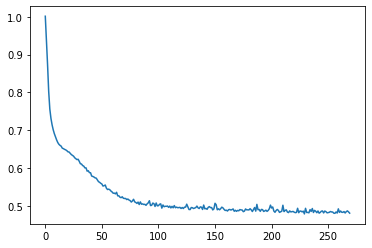

entering model mass


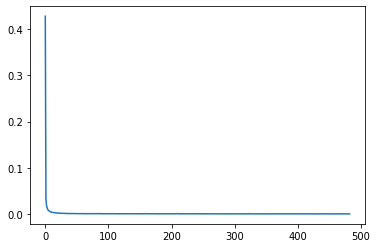

entering model rho


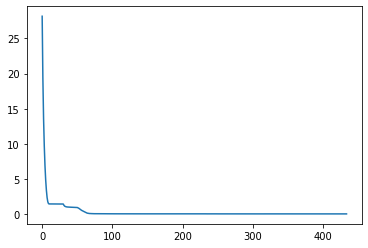

In [4]:
grub = RhoProf(data)
maxrho, xcoords, profiles = grub.pred_prof([[13, 1, 0.08]])

In [5]:
print(maxrho)

[[2.6562383]]


In [8]:
print(profiles)
max(profiles[0])

[[ 1.28143897e+01  1.27779764e+01  1.27535067e+01  1.27334491e+01
   1.27150445e+01  1.26979261e+01  1.26821449e+01  1.26670455e+01
   1.26525196e+01  1.26384600e+01  1.26247888e+01  1.26114394e+01
   1.25984361e+01  1.25856534e+01  1.25731015e+01  1.25607379e+01
   1.25485799e+01  1.25366009e+01  1.25247811e+01  1.25130770e+01
   1.25015089e+01  1.24900535e+01  1.24787146e+01  1.24674658e+01
   1.24562963e+01  1.24452203e+01  1.24342351e+01  1.24233147e+01
   1.24124793e+01  1.24016701e+01  1.23908985e+01  1.23801888e+01
   1.23694891e+01  1.23588541e+01  1.23482119e+01  1.23376442e+01
   1.23270819e+01  1.23164911e+01  1.23059498e+01  1.22954457e+01
   1.22849164e+01  1.22744343e+01  1.22639297e+01  1.22534268e+01
   1.22428653e+01  1.22323620e+01  1.22218753e+01  1.22113683e+01
   1.22008486e+01  1.21903370e+01  1.21798089e+01  1.21692668e+01
   1.21586850e+01  1.21481435e+01  1.21375485e+01  1.21269061e+01
   1.21163107e+01  1.21057108e+01  1.20950472e+01  1.20843482e+01
   1.20736

12.814389705657959

In [9]:
valid_m1 = [prof.get('m1') for prof in valid]
valid_m2 = [prof.get('m2') for prof in valid]
valid_p = [prof.get('p') for prof in valid]
valid_x = [[valid_m1[i],valid_m2[i],valid_p[i]] for i in range(len(valid_m1))]

model = BaseIFInterpolator(filename = "/home/tem7290/b1119/prs5019/POSYDON/data/POSYDON_data/CO-HeMS/interpolators/linear3c_kNN/grid_0.0142.pkl")
valid_linx = []
m1list = []
plist = []
for inp in valid_x:
    if model.test_classifier("interpolation_class", np.array([inp])) == 'unstable_MT':
        valid_linx.append(inp)
        m1list.append(inp[0])
        plist.append(inp[2])

In [24]:
maxlist = []
for inp in valid_linx:
    max_rho, xcoords, profiles = grub.pred_prof([inp])
    maxlist.append(max_rho[0][0])

unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable


In [26]:
# PREDICTIONS BASED ON VALIDATION DATA
yo = px.scatter_3d(
    x=m1list,
    y=plist,
    z=maxlist,
    title='Max rho (unstable MT)'
)
yo.update_layout(scene = dict(
                        xaxis_title = 'm1',
                        yaxis_title = 'p', 
                        zaxis_title = 'max rho'))
yo.show()

In [29]:
# ACTUAL VALIDATION DATA
true_maxlist = []
model = BaseIFInterpolator(filename = "/home/tem7290/b1119/prs5019/POSYDON/data/POSYDON_data/CO-HeMS/interpolators/linear3c_kNN/grid_0.0142.pkl")
for prof in valid:
    inp = [prof.get('m1'), prof.get('m2'), prof.get('p')]
    mt_type = model.test_classifier("interpolation_class", np.array([inp]))
    if mt_type == 'unstable_MT':
        true_maxlist.append(prof.get('max_logrho'))
        

[2.438181014744281,
 2.574587338955862,
 2.737128826402885,
 2.3826487697661785,
 2.2711510118093323,
 2.4210215535598643,
 2.5525236616186304,
 2.2684408667861122,
 2.670609363426509,
 4.519645198326976,
 2.3423307019205,
 6.912305467572959,
 4.494318078186953,
 2.5322816109355846,
 2.2755722059578085,
 2.576792242172289,
 2.3705756780351033,
 2.2697129704636443,
 2.3499855358507467,
 2.782413829552596,
 2.3299561891365688,
 2.5454857581589105,
 2.3430411332221053,
 2.429587907239859,
 2.627044012135058,
 2.313640335115974,
 2.5206512154602354,
 2.4480881671817176,
 2.7589315463852113,
 2.4331320889021444,
 2.7721190982069412,
 2.4000855454099965,
 2.2973005197240877,
 2.3970642781389286,
 4.309437528999032,
 2.388145735179253,
 2.578298748865263,
 2.5629781002166094,
 2.2571007118795596,
 2.3165352503516456,
 2.830488179620069,
 2.2416056508601665,
 2.4673132196735987,
 2.724234503484775,
 2.3021148486461542,
 2.4119500321141003,
 2.2798519365003798,
 2.4657505125475274,
 2.327550411

In [34]:
# Actual validation max logrho

plot = px.scatter_3d(
    x=m1list,
    y=plist,
    z=true_maxlist,
    title='True max rho (unstable MT)'
)
plot.update_layout(scene = dict(
                        xaxis_title = 'm1',
                        yaxis_title = 'p', 
                        zaxis_title = 'max rho'))
plot.show()

In [33]:
mae(true_maxlist, maxlist)

0.07031875384588249